# MLP on ECFP4 fingerprints

**Goal.** Train a baseline neural network for cancer vs. non-cancer on binary ECFP4 fingerprints and compare operating points (default 0.50, tuned-F1, screening 0.20, recall-targeted).

- **Input:** `ecfp_final.csv` with `fp_0 … fp_2047` (2048 bits) and `Label` (0/1).
- **Model:** `MLPClassifier` inside a pipeline with `StandardScaler` and `SelectFromModel(LogisticRegression)` for embedded feature selection.
- **Why FS before MLP?** LR weights highlight informative bits; pruning reduces noise and speeds up MLP training.


## Setup

- Libraries: `scikit-learn`, `pandas`, `numpy`, `matplotlib`, `seaborn`.
- Mount Drive (Colab) to read/write CSVs.


In [ ]:
# Imports (core + modeling + metrics)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve, confusion_matrix
)

from scipy.stats import loguniform


## Load data

- Read `ecfp_final.csv`.
- Features: 2048-bit ECFP columns.
- Target: `Label` cast to integer.


In [ ]:
# Colab I/O: hook into Drive so the CSV is accessible
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# Load the CSV with ECFP fingerprints + Label
df = pd.read_csv('/content/drive/My Drive/ecfp_final.csv')

# Assuming your CSV has columns like fp_0, fp_1, ..., fp_2047
X = df[[f'fp_{i}' for i in range(2048)]].values

# Labels
y = df['Label'].astype(int).values

## Data split

- **Validation**: hold out 20% to tune thresholds and report early results.  
- **Train/Test**: split the remaining 80% into 70% train and 10% test.  
- All splits are **stratified** and use `random_state=42`.

In [ ]:
# Hold out 20% for validation
X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split remaining 80% into train and test
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42)

print("Train:", X_train.shape)
print("Test:", X_test.shape)
print("Validation:", X_val.shape)


Train: (8613, 2048)
Test: (1231, 2048)
Validation: (2462, 2048)


### Model pipeline (MLP)

- **Preprocessing:** `StandardScaler(with_mean=True, with_std=True)`.

- **Feature selection:** `SelectFromModel(LogisticRegression(solver="liblinear", class_weight="balanced", max_iter=1000))`
  with `threshold ∈ {"median","mean"}` (embedded FS before MLP).

- **Classifier:** `MLPClassifier(solver="adam", early_stopping=True, validation_fraction=0.15,
  n_iter_no_change=10, max_iter=250, random_state=42)`.

- **Search space (RandomizedSearchCV):**
  - `select__threshold ∈ {"median", "mean"}`
  - `mlp__hidden_layer_sizes ∈ {(128,), (256,), (128, 64), (256, 128), (128, 64, 32)}`
  - `mlp__activation ∈ {"relu", "tanh"}`
  - `mlp__alpha ~ loguniform(1e-5, 1e-2)`  *(L2)*
  - `mlp__learning_rate_init ~ loguniform(1e-4, 5e-2)`
  - `mlp__batch_size ∈ {32, 64, 128}`

- **CV:** `StratifiedKFold(n_splits=3, shuffle=True, random_state=42)`.

- **Search config:** `RandomizedSearchCV(n_iter=40, scoring="average_precision", n_jobs=-1, refit=True)`.

- **Scoring rationale:** `average_precision` (PR-AUC) is more informative under class imbalance; also report ROC-AUC.

- **Report:** best hyperparameters, number of selected bits after refit, and validation metrics at
  `thr=0.50`, `thr=tuned(F1)`, `thr=0.20` (screening), and `recall-target` threshold.

- **Optional stability:** after search, set `mlp__max_iter=400` and refit the best pipeline.


In [ ]:
rng = 42

# Pipeline: Scale -> FS(LR selector) -> MLP
mlp_pipe = Pipeline([
    ("scale", StandardScaler(with_mean=True, with_std=True)),
    ("select", SelectFromModel(
        LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear"),
        threshold="median"    # keep top ~50%; can also tune
    )),
    ("mlp", MLPClassifier(
        solver="adam",
        random_state=rng,
        max_iter=250,             # search-time budget
        early_stopping=True,      # internal validation within folds (ok inside CV)
        validation_fraction=0.15,
        n_iter_no_change=10
    ))
])

# Search space (compact, effective)
param_dist = {
    "select__threshold": ["median", "mean"],

    # architectures
    "mlp__hidden_layer_sizes": [(128,), (256,), (128, 64), (256, 128), (128, 64, 32)],
    "mlp__activation": ["relu", "tanh"],

    # regularization / lr / batch size
    "mlp__alpha": loguniform(1e-5, 1e-2),         # L2
    "mlp__learning_rate_init": loguniform(1e-4, 5e-2),
    "mlp__batch_size": [32, 64, 128],
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=rng)

mlp_search = RandomizedSearchCV(
    estimator=mlp_pipe,
    param_distributions=param_dist,
    n_iter=40,
    scoring="average_precision",
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=rng,
    refit=True
)

# Fit on TRAIN
mlp_search.fit(X_train, y_train)

best_mlp = mlp_search.best_estimator_
print("Best MLP params:", mlp_search.best_params_)

# increase max_iter and refit best pipeline on TRAIN for stability
best_mlp.set_params(mlp__max_iter=400)
best_mlp.fit(X_train, y_train)

# report how many features were selected after final refit
n_selected = int(best_mlp.named_steps["select"].get_support().sum())
print("Selected features:", n_selected)

# Probabilities for your existing validation/test blocks
y_val_prob  = best_mlp.predict_proba(X_val)[:, 1]
y_test_prob = best_mlp.predict_proba(X_test)[:, 1]

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best MLP params: {'mlp__activation': 'tanh', 'mlp__alpha': np.float64(0.0059440281134109305), 'mlp__batch_size': 64, 'mlp__hidden_layer_sizes': (256,), 'mlp__learning_rate_init': np.float64(0.000496794427866624), 'select__threshold': 'mean'}
Selected features: 847


## Validation results (default threshold 0.50)

- Predictions via for `thr=0.50`.  
- Metrics reported:
  - **Accuracy**, **Precision**, **Recall**, **F1**  
  - **ROC AUC** and **PR AUC** (threshold-free)  
- Include a **confusion matrix** heatmap with readable axis labels.


,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,MLP Validation (thr=0.50 default),0.974005,0.228571,0.177778,0.2,0.719606,0.127647


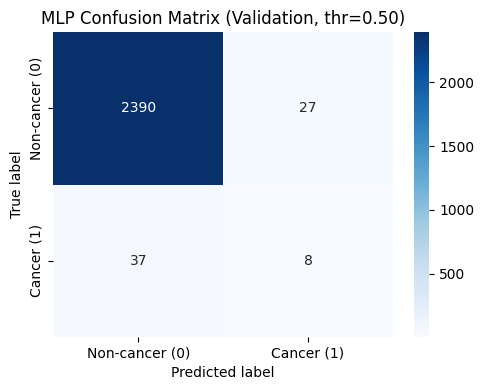

In [ ]:
# Validation @ 0.50 (default)
# Probabilities from MLP pipeline
y_val_prob = best_mlp.predict_proba(X_val)[:, 1]
y_val_pred_050 = (y_val_prob >= 0.50).astype(int)

df_mlp_val_050 = pd.DataFrame([{
    "Set": "MLP Validation (thr=0.50 default)",
    "Accuracy":  accuracy_score(y_val, y_val_pred_050),
    "Precision": precision_score(y_val, y_val_pred_050, zero_division=0),
    "Recall":    recall_score(y_val, y_val_pred_050),
    "F1 Score":  f1_score(y_val, y_val_pred_050),
    "ROC AUC":   roc_auc_score(y_val, y_val_prob),
    "PR AUC":    average_precision_score(y_val, y_val_prob)
}])
display(df_mlp_val_050)

cm = confusion_matrix(y_val, y_val_pred_050)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-cancer (0)", "Cancer (1)"],
            yticklabels=["Non-cancer (0)", "Cancer (1)"])
plt.title("MLP Confusion Matrix (Validation, thr=0.50)")
plt.ylabel("True label"); plt.xlabel("Predicted label")
plt.tight_layout(); plt.show()


## Threshold tuning by F1

- Sweep candidate thresholds from unique predicted probabilities.  
- Choose the threshold that **maximizes F1** on the validation set.  
- Recompute **Accuracy**, **Precision**, **Recall**, **F1**, **ROC AUC**, **PR AUC** at the tuned threshold.  
- Show a confusion matrix at the tuned operating point.


,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,MLP Validation (thr=tuned=0.307),0.971568,0.254902,0.288889,0.270833,0.719606,0.127647


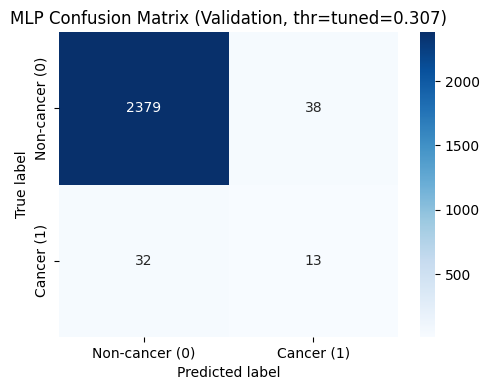

In [ ]:
# Validation @ Tuned Threshold (F1-optimal)
# Find tuned threshold
prec_v, rec_v, thr_v = precision_recall_curve(y_val, y_val_prob)  # thr_v len = len(rec_v) - 1
f1_v = (2 * prec_v[:-1] * rec_v[:-1]) / (prec_v[:-1] + rec_v[:-1] + 1e-12)
best_idx = int(np.argmax(f1_v))
mlp_tuned_thr = float(thr_v[best_idx])

y_val_pred_tuned = (y_val_prob >= mlp_tuned_thr).astype(int)

df_mlp_val_tuned = pd.DataFrame([{
    "Set": f"MLP Validation (thr=tuned={mlp_tuned_thr:.3f})",
    "Accuracy":  accuracy_score(y_val, y_val_pred_tuned),
    "Precision": precision_score(y_val, y_val_pred_tuned, zero_division=0),
    "Recall":    recall_score(y_val, y_val_pred_tuned),
    "F1 Score":  f1_score(y_val, y_val_pred_tuned),
    "ROC AUC":   roc_auc_score(y_val, y_val_prob),
    "PR AUC":    average_precision_score(y_val, y_val_prob)
}])
display(df_mlp_val_tuned)

cm = confusion_matrix(y_val, y_val_pred_tuned)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-cancer (0)", "Cancer (1)"],
            yticklabels=["Non-cancer (0)", "Cancer (1)"])
plt.title(f"MLP Confusion Matrix (Validation, thr=tuned={mlp_tuned_thr:.3f})")
plt.ylabel("True label"); plt.xlabel("Predicted label")
plt.tight_layout(); plt.show()


## Screening scenario (fixed threshold = 0.20)

- Lowering the threshold increases recall at the cost of precision—useful for screening.  
- Evaluate the validation set at `thr = 0.20` and report the same metric table plus a confusion matrix.


,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,MLP Validation (thr=0.20 screening),0.964663,0.208333,0.333333,0.25641,0.719606,0.127647


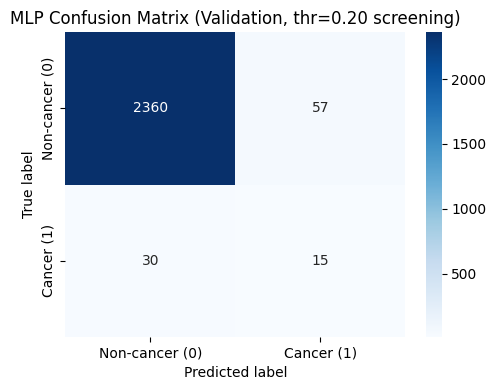

In [ ]:
# MLP: Validation @ Screening Threshold (0.20)
thr_screen = 0.20
y_val_pred_020 = (y_val_prob >= thr_screen).astype(int)

df_mlp_val_020 = pd.DataFrame([{
    "Set": "MLP Validation (thr=0.20 screening)",
    "Accuracy":  accuracy_score(y_val, y_val_pred_020),
    "Precision": precision_score(y_val, y_val_pred_020, zero_division=0),
    "Recall":    recall_score(y_val, y_val_pred_020),
    "F1 Score":  f1_score(y_val, y_val_pred_020),
    "ROC AUC":   roc_auc_score(y_val, y_val_prob),
    "PR AUC":    average_precision_score(y_val, y_val_prob)
}])
display(df_mlp_val_020)

cm = confusion_matrix(y_val, y_val_pred_020)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-cancer (0)", "Cancer (1)"],
            yticklabels=["Non-cancer (0)", "Cancer (1)"])
plt.title("MLP Confusion Matrix (Validation, thr=0.20 screening)")
plt.ylabel("True label"); plt.xlabel("Predicted label")
plt.tight_layout(); plt.show()


## Recall-targeted operating point

- Select the **smallest** threshold that achieves a target recall (e.g., `recall ≥ 0.70`), keeping precision as high as possible.  
- If the target is unattainable, fall back to `thr = 0.20`.  
- Report metrics and confusion matrix for this recall-targeted point.


,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,"MLP Validation (recall≥0.70, thr=0.000)",0.564175,0.029304,0.711111,0.056288,0.719606,0.127647


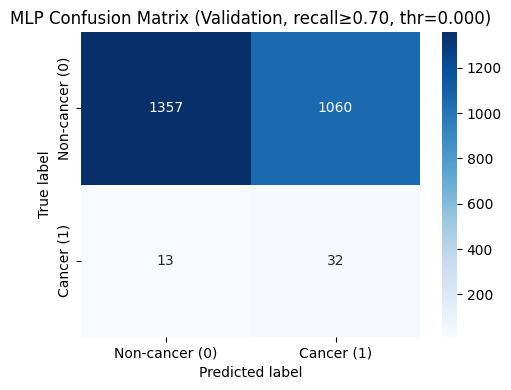

In [ ]:
# Validation @ Recall-Target Threshold
target_recall = 0.70

prec_v, rec_v, thr_v = precision_recall_curve(y_val, y_val_prob)  # thr_v len = len(rec_v) - 1
mask = rec_v[:-1] >= target_recall
if mask.any():
    idx = np.where(mask)[0][-1]          # largest τ meeting target recall
    mlp_thr_recall = float(thr_v[idx])
else:
    mlp_thr_recall = 0.20                 # fallback if unattainable

y_val_pred_recall = (y_val_prob >= mlp_thr_recall).astype(int)

df_mlp_val_recall = pd.DataFrame([{
    "Set": f"MLP Validation (recall≥{target_recall:.2f}, thr={mlp_thr_recall:.3f})",
    "Accuracy":  accuracy_score(y_val, y_val_pred_recall),
    "Precision": precision_score(y_val, y_val_pred_recall, zero_division=0),
    "Recall":    recall_score(y_val, y_val_pred_recall),
    "F1 Score":  f1_score(y_val, y_val_pred_recall),
    "ROC AUC":   roc_auc_score(y_val, y_val_prob),
    "PR AUC":    average_precision_score(y_val, y_val_prob)
}])
display(df_mlp_val_recall)

cm = confusion_matrix(y_val, y_val_pred_recall)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-cancer (0)", "Cancer (1)"],
            yticklabels=["Non-cancer (0)", "Cancer (1)"])
plt.title(f"MLP Confusion Matrix (Validation, recall≥{target_recall:.2f}, thr={mlp_thr_recall:.3f})")
plt.ylabel("True label"); plt.xlabel("Predicted label")
plt.tight_layout(); plt.show()


## Threshold sweep on validation — Methods

- **Procedure:** thresholds from `0.05` to `0.95` in steps of `0.05`.  
  For each `τ`, compute on the validation set:  
  `Precision(τ)`, `Recall(τ)`, and `F1(τ)` using `y_prob` and `ŷ = [p ≥ τ]`.
- **Plot:** three line series (Precision, Recall, F1) with markers.  
  Vertical reference lines mark key operating points:
  - `τ = 0.50` (default)
  - `τ = 0.20` (screening)
  - `τ = tuned_thr` (max-F1)
  - `τ = thr_recall` (recall-targeted)
- **Figure details:** title *“Precision / Recall / F1 vs Threshold • Validation”*,  
  x-axis = **Threshold**, y-axis = **Score**, legend on, grid enabled.

**Figure.** Precision (P), Recall (R), and F1 across thresholds, with dashed lines at chosen operating points.


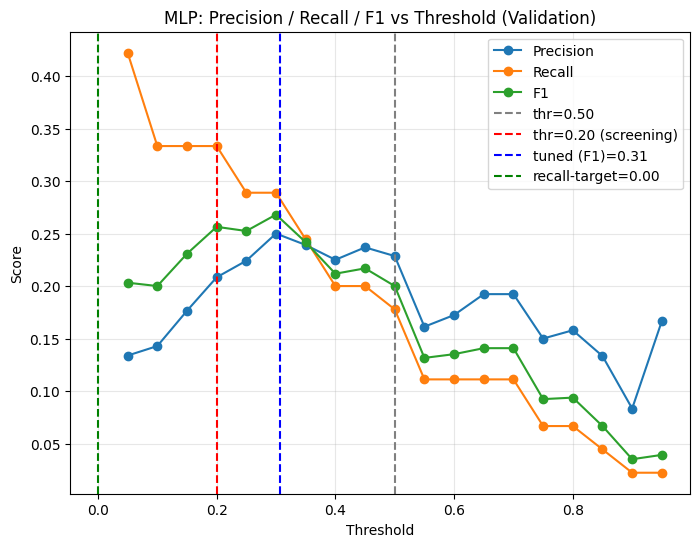

In [ ]:
#  Sweep discrete thresholds for plotting
thresholds = np.arange(0.05, 0.96, 0.05)
precisions, recalls, f1s = [], [], []
for thr in thresholds:
    y_pred_thr = (y_val_prob >= thr).astype(int) # Use y_val_prob
    precisions.append(precision_score(y_val, y_pred_thr, zero_division=0))
    recalls.append(recall_score(y_val, y_pred_thr))
    f1s.append(f1_score(y_val, y_pred_thr))

# Plot (consistent with your other models)
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, marker='o', label='Precision')
plt.plot(thresholds, recalls,   marker='o', label='Recall')
plt.plot(thresholds, f1s,       marker='o', label='F1')

# Reference lines
plt.axvline(0.50,            color='grey',  linestyle='--', label='thr=0.50')
plt.axvline(0.20,            color='red',   linestyle='--', label='thr=0.20 (screening)')
plt.axvline(mlp_tuned_thr,   color='blue',  linestyle='--', label=f'tuned (F1)={mlp_tuned_thr:.2f}')
plt.axvline(mlp_thr_recall,  color='green', linestyle='--', label=f'recall-target={mlp_thr_recall:.2f}')

plt.title('MLP: Precision / Recall / F1 vs Threshold (Validation)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## ROC curve — Validation

- **Computation:** `fpr_v, tpr_v, _ = roc_curve(y_val, y_val_prob)` with `roc_auc_val = roc_auc_score(y_val, y_val_prob)`.  
- **Plot:** TPR vs FPR with the diagonal `y = x` as a reference (no-skill).  
- **Reading the figure:** curves further above the diagonal indicate better ranking of positives over negatives; **AUC** summarizes this ranking independent of any threshold.



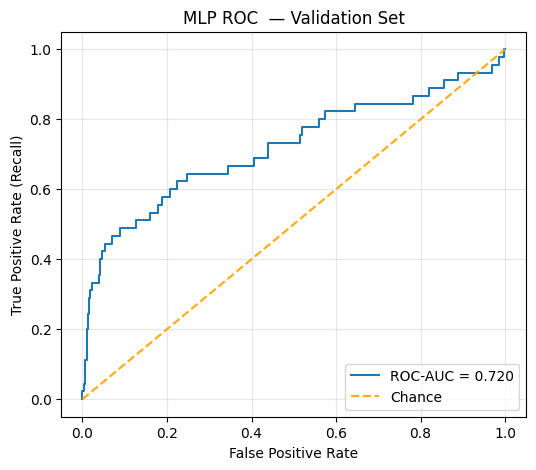

In [ ]:
# ROC Curve
fpr_v, tpr_v, _ = roc_curve(y_val, y_val_prob)
roc_auc_val = roc_auc_score(y_val, y_val_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr_v, tpr_v, label=f"ROC-AUC = {roc_auc_val:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="orange", lw=1.6, alpha=0.9, label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("MLP ROC  — Validation Set")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


## Precision–Recall (PR) curve — Validation

- **Computation:** `prec, rec, _ = precision_recall_curve(y_val, y_val_prob) ` and **Average Precision (AP)** via `average_precision_score(y_val, y_val_prob)`.  
- **Plot:** Precision vs Recall; AP is shown in the legend.  
- **Reading the figure:** with class imbalance, PR curves are more informative than ROC.  
  The **baseline precision** equals the positive prevalence `π = (#positives / #samples)`; curves well above this line indicate useful enrichment.


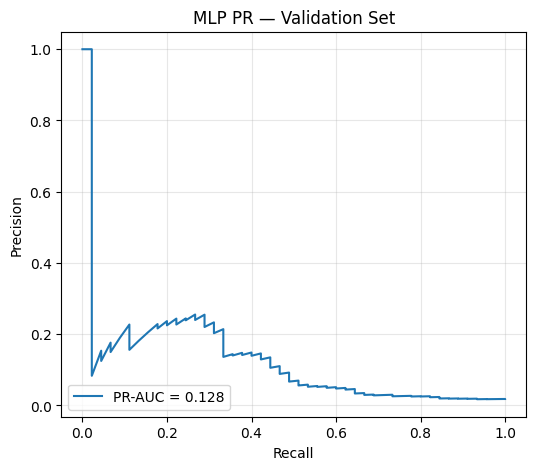

Validation ROC-AUC = 0.720 | PR-AUC = 0.128


In [ ]:
# PR Curve
prec, rec, _ = precision_recall_curve(y_val, y_val_prob)
pr_auc_val = average_precision_score(y_val, y_val_prob)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"PR-AUC = {pr_auc_val:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("MLP PR — Validation Set")
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Validation ROC-AUC = {roc_auc_val:.3f} | PR-AUC = {pr_auc_val:.3f}")

## Test-set evaluation

**Goal:** apply the model (fixed from training/validation) to the held-out **test set** and report performance at several operating points.

- **Probabilities:** compute `y_test_prob_mlp = best_mlp.predict_proba(X_test)[:, 1]`.
- **Thresholds evaluated:**
  - `τ = tuned_thr` (chosen on **validation** by max-F1)  
  - `τ = 0.50` (default)  
  - `τ = 0.20` (screening)  
  - `τ = thr_recall` (smallest τ that met the recall target on validation)
- **Leakage control:** thresholds are **carried over from validation**; no re-tuning on test.


MLP TEST • Threshold-free
ROC-AUC: 0.641 | PR-AUC: 0.045


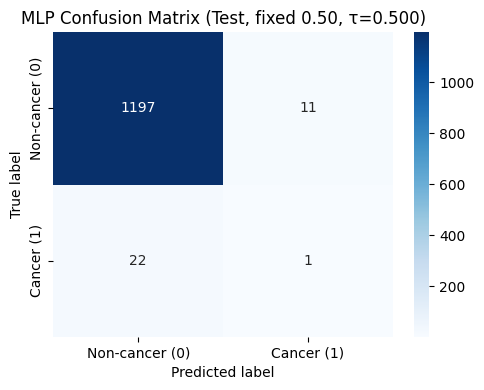

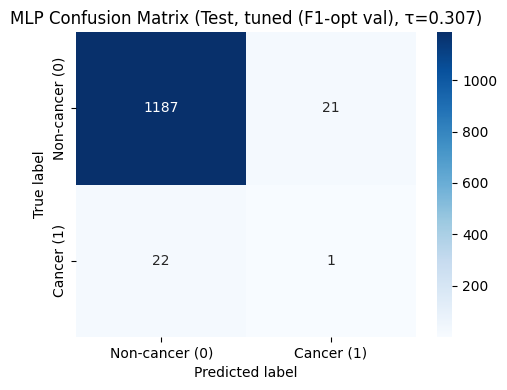

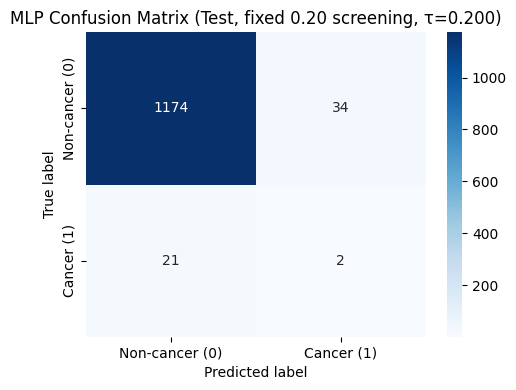

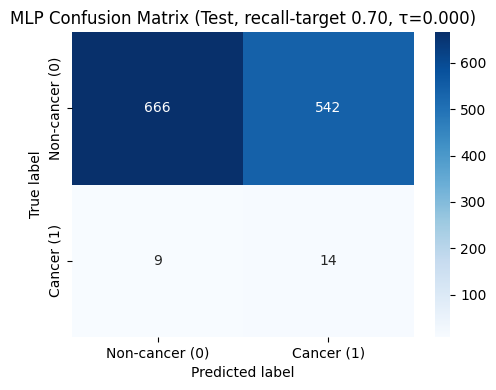

,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,"MLP Test (fixed 0.50, τ=0.500)",0.973193,0.083333,0.043478,0.057143,0.641124,0.044867
1,"MLP Test (tuned (F1-opt val), τ=0.307)",0.965069,0.045455,0.043478,0.044444,0.641124,0.044867
2,"MLP Test (fixed 0.20 screening, τ=0.200)",0.955321,0.055556,0.086957,0.067797,0.641124,0.044867
3,"MLP Test (recall-target 0.70, τ=0.000)",0.552396,0.025180,0.608696,0.048359,0.641124,0.044867



Chosen thresholds → tuned(F1): 0.3073 | recall≥0.70: 0.0004


In [18]:
#TEST SET EVALUATION
# F1-opt tuned threshold from VALIDATION (compute if not already defined)
try:
    mlp_tuned_thr
except NameError:
    prec_v, rec_v, thr_v = precision_recall_curve(y_val, y_val_prob)  # len(thr_v)=len(rec_v)-1
    f1_v = (2 * prec_v[:-1] * rec_v[:-1]) / (prec_v[:-1] + rec_v[:-1] + 1e-12)
    mlp_tuned_thr = float(thr_v[int(np.argmax(f1_v))])

# Recall-target threshold from VALIDATION (largest τ meeting target)
target_recall = 0.70
try:
    mlp_thr_recall
except NameError:
    prec_v, rec_v, thr_v = precision_recall_curve(y_val, y_val_prob)
    mask = rec_v[:-1] >= target_recall
    if mask.any():
        idx = np.where(mask)[0][-1]
        mlp_thr_recall = float(thr_v[idx])
    else:
        mlp_thr_recall = 0.20  # sensible fallback

# Threshold-free metrics (TEST)
roc_auc_test = roc_auc_score(y_test, y_test_prob)
pr_auc_test  = average_precision_score(y_test, y_test_prob)
print("MLP TEST • Threshold-free")
print(f"ROC-AUC: {roc_auc_test:.3f} | PR-AUC: {pr_auc_test:.3f}")

# Helper: evaluate + plot (same style as your other models)
def evaluate_and_plot_mlp_test(y_true, y_prob, thr_value, label):
    y_pred = (y_prob >= thr_value).astype(int)
    row = {
        "Set":       f"MLP Test ({label}, τ={thr_value:.3f})",
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall":    recall_score(y_true, y_pred),
        "F1 Score":  f1_score(y_true, y_pred),
        "ROC AUC":   roc_auc_score(y_true, y_prob),           # threshold-free
        "PR AUC":    average_precision_score(y_true, y_prob)  # threshold-free
    }
    df = pd.DataFrame([row])

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=["Non-cancer (0)", "Cancer (1)"],
        yticklabels=["Non-cancer (0)", "Cancer (1)"]
    )
    plt.title(f"MLP Confusion Matrix (Test, {label}, τ={thr_value:.3f})")
    plt.ylabel("True label"); plt.xlabel("Predicted label")
    plt.tight_layout(); plt.show()
    return df

# Evaluate at 0.50, tuned (F1 on val), 0.20, and recall-target
tables_mlp_test = []
tables_mlp_test.append(evaluate_and_plot_mlp_test(y_test, y_test_prob, 0.50,           "fixed 0.50"))
tables_mlp_test.append(evaluate_and_plot_mlp_test(y_test, y_test_prob, mlp_tuned_thr,  "tuned (F1-opt val)"))
tables_mlp_test.append(evaluate_and_plot_mlp_test(y_test, y_test_prob, 0.20,           "fixed 0.20 screening"))
tables_mlp_test.append(evaluate_and_plot_mlp_test(y_test, y_test_prob, mlp_thr_recall, f"recall-target {target_recall:.2f}"))

# Compact combined table
mlp_test_summary = pd.concat(tables_mlp_test, ignore_index=True)
display(mlp_test_summary)

print(f"\nChosen thresholds → tuned(F1): {mlp_tuned_thr:.4f} | recall≥{target_recall:.2f}: {mlp_thr_recall:.4f}")

## ROC curve — Test Set

- **Computation:** `fpr_t, tpr_t, _ = roc_curve(y_test, y_test_prob)` and `roc_auc_test = roc_auc_score(y_test, y_test_prob)`.  
- **Display:** plot TPR vs FPR with the diagonal `y = x` as the no-skill reference.  
- **Interpretation:** the farther the curve bows above the diagonal, the better the ranking of positives over negatives. AUC summarizes this ranking and is **threshold-free**.



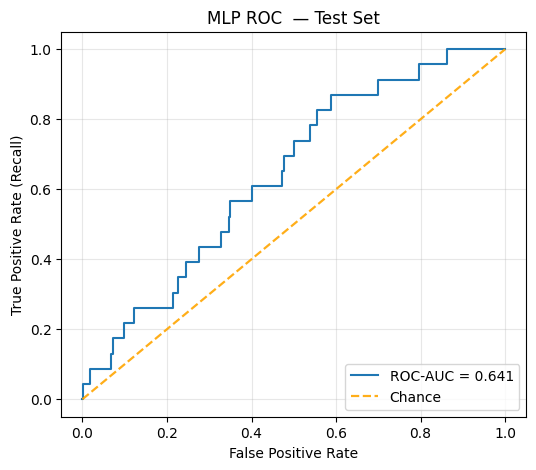

In [19]:
# ROC Curve
fpr_t, tpr_t, _ = roc_curve(y_test, y_test_prob) #
roc_auc_test = roc_auc_score(y_test, y_test_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr_t, tpr_t, label=f"ROC-AUC = {roc_auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="orange", lw=1.6, alpha=0.9, label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("MLP ROC  — Test Set")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


## Precision–Recall (PR) curve — Test Set

- **Computation:** `prec_t, rec_t, _ = precision_recall_curve(y_test, y_test_prob)` and **Average Precision (AP)** via `average_precision_score(y_test, y_test_prob)`.  
- **Display:** Precision vs Recall with AP shown in the legend.  
- **Interpretation:** PR is more informative than ROC under class imbalance. The implicit baseline equals the positive prevalence; curves well above baseline indicate useful enrichment.


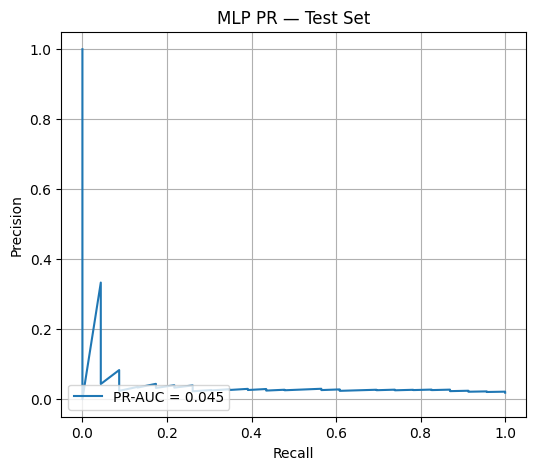

Test ROC-AUC = 0.641 | PR-AUC = 0.045


In [20]:
# PR Curve
prec_t, rec_t, _ = precision_recall_curve(y_test, y_test_prob)
pr_auc_test = average_precision_score(y_test, y_test_prob)

plt.figure(figsize=(6,5))
plt.plot(rec_t, prec_t, label=f"PR-AUC = {pr_auc_test:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("MLP PR — Test Set")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

print(f"Test ROC-AUC = {roc_auc_test:.3f} | PR-AUC = {pr_auc_test:.3f}")